In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
from copy import deepcopy
from sklearn.linear_model import LinearRegression

from utils import *
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

import warnings
warnings.filterwarnings("ignore")

### Train closed-loop low-rank RNN on double integrator task 

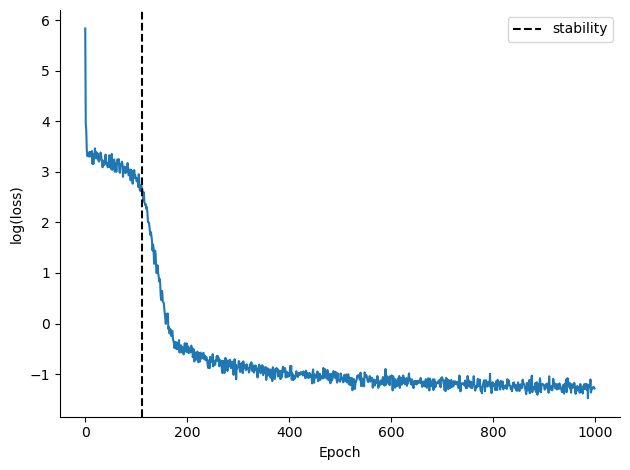

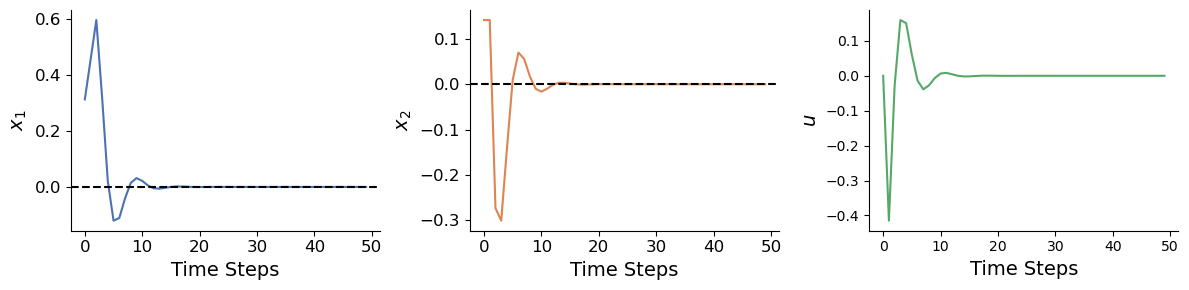

In [2]:
N = 100
system = k_integrator_torch(k=2, dt=1, c=1, m=1)
model = P_Model(N=N, g=0.0, rank=1, system=system) # Instantiate the model
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) # Instantiate the optimizer
num_epochs = 1000
loss,model_his_parameters, grad = train_model_p(model,
                                              optimizer,
                                              teacher=None,
                                              white_noise=None,
                                              w_grad_clip=True,
                                              num_epochs=num_epochs,
                                              batch_size=100,
                                              num_steps=50,
                                              clamp=False)


all_P = []

for ep in range(num_epochs):
    model = model_his_parameters[ep]
    P = create_p_matrix_from_low_rank(model.system, model.N, model.M, model.Z, model.U, model.V, model.W_random)
    all_P.append(P.detach().numpy())
    
all_P = np.array(all_P)
eig,_ = np.linalg.eig(np.array(all_P))
stab = np.all(np.abs(eig) < 1, axis=1).astype(int)

try:
    for i in range(num_epochs):
        if stab[i] == 1 and all(stab[i:] == [1] * (len(stab) - i)):
            ep_of_stab = i
            break
except:
    ep_of_stab = num_epochs+1

all_eig_whh = []
for ep in range(num_epochs):
    eig,_ = np.linalg.eig(all_P[ep,2:,2:])
    all_eig_whh.append(eig)
    
all_eig_whh = np.array(all_eig_whh)

plt.plot(np.log(loss))
plt.axvline(x=ep_of_stab,ls='--',color='k',label='stability')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('log(loss)')

plt.tight_layout()
sns.despine()
plt.show()

tt,uu = simulate_p(P,50,N)
fig,ax = plt.subplots(1,3,figsize=(12, 3))
for i in range(2):
    ax[i].plot(torch.stack(tt).squeeze().detach().numpy()[:,i],color=sns.color_palette('deep')[i])
    ax[i].axhline(y=0, color='k', ls='--', label='Target')
    ax[i].set_xlabel('Time Steps',size=14) 
    ax[i].set_ylabel(f'$x_{i+1}$',size=14) 
    ax[i].tick_params(axis='both', which='major', labelsize=12)


ax[2].plot(torch.stack(uu).squeeze().detach().numpy(),color=sns.color_palette('deep')[2])
ax[2].set_xlabel('Time Steps',size=14) 
ax[2].set_ylabel(f'$u$',size=14) 
sns.despine()
plt.tight_layout()
plt.show()


### Stage-1: Effective loss using geometric sum $\lambda_1 \approx 1 + \sqrt{\sigma_{zm}}$

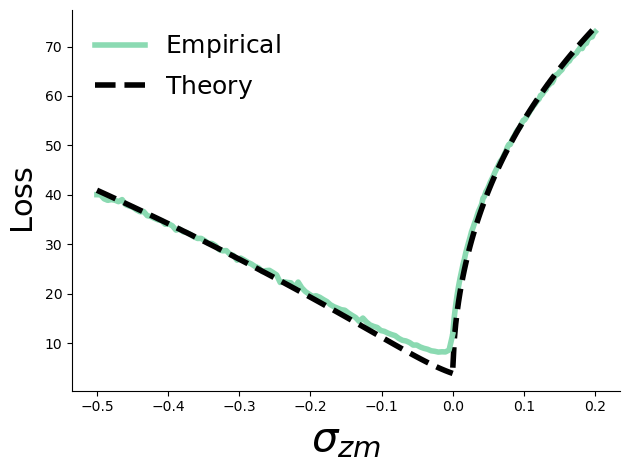

In [3]:
num_steps = 100

# stage 1 
def run_traj(P,num_steps=50):
    x0 = np.array([[1]]) # np.random.uniform(-2, 2, (1,1))
    x1 = np.array([[-1]]) # np.random.uniform(-2, 2, (1,1))
    h0 = np.zeros((model.N,1))
    h = torch.tensor(np.vstack((x0, x1, h0)), dtype=torch.float32)
    tt = [] 
    for i in range(num_steps):
        tt.append(h[:2])
        h = P@h
    return torch.stack(tt).squeeze().detach().numpy()

zm_pos = np.linspace(0.0001, 0.2, 100)
loss_sim_pos = []
loss_the_pos = [] 

for i,cur_zm in enumerate(zm_pos):
    model = P_Model(N=N, g=0.0, system=system, over=cur_zm) # Instantiate the model
    P = create_p_matrix_from_low_rank(model.system, model.N, model.M, model.Z, model.U, model.V, model.W_random)
    traj = run_traj(P,num_steps=num_steps)
    _loss = np.sum( 0.5*(traj[:, 0]**2 + traj[:, 1]**2))
    loss_sim_pos.append(_loss)
    T = num_steps  + 1 
    r  = (np.abs(1 + np.sqrt(cur_zm + 0j))) **2 
    loss_the_pos.append( 0.5 * (1 - r**T) / (1 - r))
    

zm_neg = np.linspace(-0.5, -0.0001, 100)
loss_sim_neg = []
loss_the_neg = [] 

for i,cur_zm in enumerate(zm_neg):
    model = P_Model(N=N, g=0.0, system=system, over=cur_zm) # Instantiate the model
    P = create_p_matrix_from_low_rank(model.system, model.N, model.M, model.Z, model.U, model.V, model.W_random)
    traj = run_traj(P,num_steps=num_steps)
    _loss = np.sum( 0.5* (traj[:, 0]**2 + traj[:, 1]**2))
    loss_sim_neg.append(_loss)
    T = num_steps + 1 
    r  = (np.abs(1 + np.sqrt(cur_zm + 0j))) ** 2
    loss_the_neg.append( 0.5 * (1 - r**T) / (1 - r))

plt.plot(zm_pos, np.log(loss_sim_pos),color=sns.color_palette('mako_r')[0], lw=4, label=r'$\text{Empirical}$')
plt.plot(zm_pos, np.log(loss_the_pos), '--k', lw=4, label=r'$\text{Theory}$')
plt.plot(zm_neg, np.log(loss_sim_neg), color=sns.color_palette('mako_r')[0], lw=4)
plt.plot(zm_neg, np.log(loss_the_neg), '--k', lw=4)

plt.legend(fontsize=18, loc='upper left',frameon=False,)

plt.xlabel(r'$ \sigma_{zm} $',size=30)
plt.ylabel(r"$\text{Loss}$",size=22)

plt.tight_layout()
sns.despine()
plt.show()

### Stage-2: Effective loss with $\alpha$ hyperparameter controlling the weighting of short- and long-term contributions

We simulate optimization in a reduced model using closed-form approximation of $\lambda_3$ as a function of order parameters.  
The effective loss combines a short-term surrogate $\mathcal{L}_0$ and a long-term $\mathcal{L}_\infty^T$, weighted by $\alpha$, which acts analogously to episode length $T$ in the full model.  
Varying $\alpha$ reveals eigenvalue trajectories that reflect different trade-offs between early episode control and long-term stability.

#### Helper to computes $\mathcal{L}_0$ using low-order matrix powers of $P^n$

In [4]:
# help compute loss_0 (P^n) where n is small eg 1,2,3,4
import sympy

# Define symbols
vu, zm, vm, zu,  = sympy.symbols('vu zm vm zu', complex=True)

# Corrected matrix P
P_eff = sympy.Matrix([
    [1, 1, 0,    0],
    [0, 1, zm,  zu],
    [1, 1, 0,  0 ],
    [0, 0, vm,  vu ]
])

P_eff = P_eff**3
expr = sympy.simplify( P_eff[0,0]**2  + P_eff[1,0]**2 +  P_eff[0,1]**2 + P_eff[1,1]**2 )
expr

(zm + 1)**2 + (zm + 3)**2 + (vm*zu + 2*zm)**2 + (vm*zu + 3*zm + 1)**2

#### Helper to verify the perturbative approximation around $\lambda_3$ for computing $\mathcal{L}_\infty$

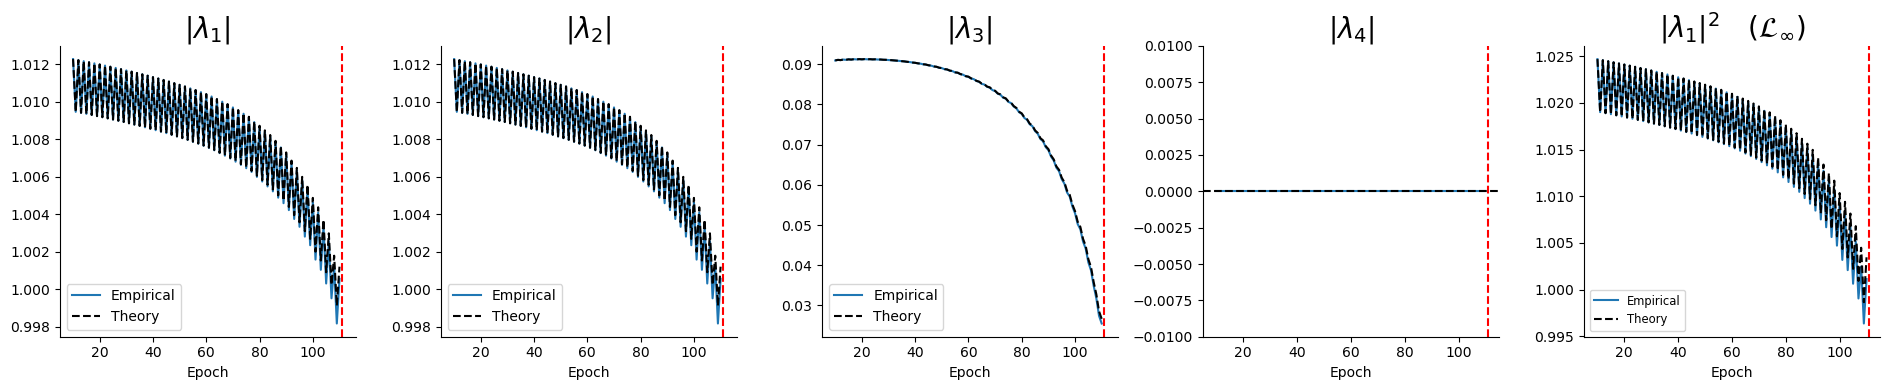

In [5]:
def quadSolver(a, b, c, tol=1e-18):
    if a == b == 0:
        print('Invalid equation.' if c != 0 else 'Trivial identity: 0 = 0')
        return
    if a == 0:
        return [-c / b]
    D = b**2 - 4 * a * c
    return [(-b - np.sqrt(D)) / (2 * a), (-b + np.sqrt(D)) / (2 * a)]

def compute_eps_order(m, z, u, v, lam, order=2):
    a = 3 * lam - (v @ u + 2)
    b = 3 * lam**2 - 2 * lam * (v @ u + 2) + (2 * v @ u - z @ m + 1)
    c = lam**3 - (v @ u + 2) * lam**2 + (2 * v @ u - z @ m + 1) * lam + \
        (v @ u) * (z @ m) - v @ u - (v @ m) * (z @ u)
    if order == 2:
        roots = quadSolver(a, b, c)
        return roots[0] if len(roots) > 1 else roots[1]
    return -c / b if b != 0 else 0

scan_ep = np.arange(10, ep_of_stab, 1)

# === Eigenvalue evolution ===
eig_empirical = []
for ep in scan_ep:
    eigvals, _ = np.linalg.eig(all_P[ep])
    sorted_eigs = np.sort(np.abs(eigvals))[::-1]
    eig_empirical.append(sorted_eigs)
eig_empirical = np.array(eig_empirical)

# === Init figure ===
fig, ax = plt.subplots(1, 5, figsize=(19, 4))
for i in range(4):
    ax[i].set_title(f'$| \lambda_{{{i+1}}} |$',size=20)
    ax[i].set_xlabel('Epoch')
    ax[i].plot(scan_ep, np.abs(eig_empirical[:, i]), label='Empirical')
    ax[i].axvline(x=ep_of_stab, ls='--', color='r')
    

# === Roots of characteristic poly ===
poly_root1, poly_root2, poly_root3 = [], [], []
root1_theory = [] 
root3_theory = [] 
for ep in scan_ep:
    model = model_his_parameters[ep]
    m, z, u, v = map(lambda x: x.detach().numpy().flatten(), [model.M, model.Z, model.U, model.V])
    coeffs = [1, -v @ u - 2, 2 * v @ u - z @ m + 1, (v @ u)*(z @ m) - v @ u - (v @ m)*(z @ u)]
    roots = np.roots(coeffs)
    poly_root1.append(roots[0])
    poly_root2.append(roots[1])
    poly_root3.append(roots[2])

    lam = 1 + np.sqrt(z@m + 0j)
    root1_theory.append(lam + compute_eps_order(m, z, u, v, lam,))
    root3_theory.append(v @ u + ((v @ m)*(z @ u)) / ((v @ u)**2 - 2*v @ u - z @ m + 1))

# ax[0].plot(scan_ep, np.abs(poly_root1), '--', color='g', label='Empirical')
# ax[1].plot(scan_ep, np.abs(poly_root2), '--', color='g', label='Empirical')
# ax[2].plot(scan_ep, np.abs(poly_root3), '--', color='g', label='Empirical')

ax[0].plot(scan_ep, np.abs(root1_theory), '--', color='k', label='Theory')
ax[1].plot(scan_ep, np.abs(root1_theory), '--', color='k', label='Theory')
ax[2].plot(scan_ep, np.abs(root3_theory), '--', color='k', label='Theory')

ax[0].legend()
ax[1].legend()
ax[2].legend()

# === Add uᵀv line ===
inner_uv = []
for ep in scan_ep:
    model = model_his_parameters[ep]
    u, v = model.U.detach().numpy().flatten(), model.V.detach().numpy().flatten()
    inner_uv.append(u @ v)
# ax[2].plot(scan_ep, np.abs(inner_uv), '--', color='gray', label=r'$u^{\top}v$',alpha=0.4)
ax[2].legend()

# === Center axis line ===
ax[3].axhline(y=0, ls='--', color='k')
ax[3].set_ylim(-0.01, 0.01)

# === Analytic vs Empirical λ₁² ===
s_empirical, s_theory, s_theory_uv = [], [], []
for ep in scan_ep:
    model = model_his_parameters[ep]
    m, z, u, v = map(lambda x: x.detach().numpy().flatten(), [model.M, model.Z, model.U, model.V])
    eigvals, _ = np.linalg.eig(all_P[ep])
    idx = np.argsort(np.abs(eigvals))[::-1]
    λ3 = eigvals[idx[2]]
    s_empirical.append(np.abs(eigvals[idx[1]]**2))

    b = -v @ u - 2
    c = 2 * v @ u - z @ m + 1
    λ3_approx = v @ u + ((v @ m)*(z @ u)) / ((v @ u)**2 - 2*v @ u - z @ m + 1)
    s_theory.append(c + b * λ3_approx + λ3_approx**2)
    s_theory_uv.append(c + b * (u @ v) + (u @ v)**2)

ax[4].set_title(r'$|\lambda_1|^2 \quad (\mathcal{L}_\infty)$',size=20)
ax[4].plot(scan_ep, s_empirical, label='Empirical')
ax[4].plot(scan_ep, s_theory, '--', color='k', label='Theory')
# ax[4].plot(scan_ep, s_theory_uv, '--', color='gray', label=r'$c + b u^{\top}v + (u^{\top}v)^2$', alpha=0.4)
ax[4].axvline(x=ep_of_stab, ls='--', color='red')
ax[4].set_xlabel('Epoch')
ax[4].legend(fontsize='small')


sns.despine()
plt.tight_layout()
plt.show()


### Optimize effective loss $\alpha \mathcal{L}_\infty^T + (1{-}\alpha)\mathcal{L}_0$ across varying $\alpha$

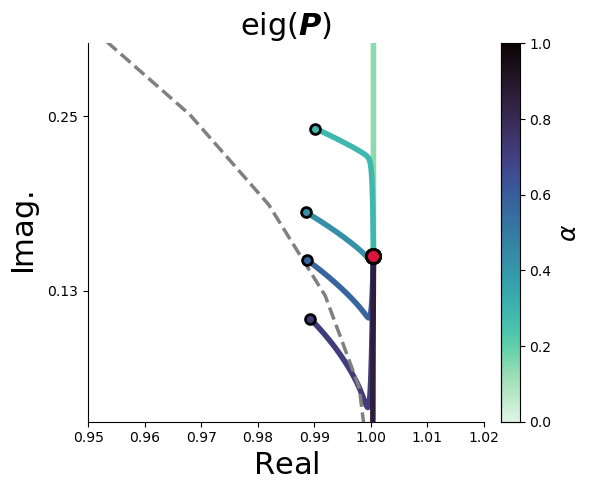

In [6]:
palette = sns.color_palette('mako_r')
alphas = [0, 0.2, 0.3, 0.35, 0.4, 1.0]
norm = Normalize(vmin=min(alphas), vmax=max(alphas))
cmap = plt.get_cmap('mako_r')

fig, ax = plt.subplots(figsize=(6, 5))  # capture fig and ax

# stage 2 
class ReduceModel(nn.Module):
    def __init__(self, vu=0, zm=0.01, vm=0, zu=0, alpha=0.01, T=10):
        super().__init__()
        self.vu = nn.Parameter(torch.tensor(vu, dtype=torch.float32))
        self.zm = nn.Parameter(torch.tensor(zm, dtype=torch.float32))
        self.vm = nn.Parameter(torch.tensor(vm, dtype=torch.float32))
        self.zu = nn.Parameter(torch.tensor(zu, dtype=torch.float32))
        self.alpha = alpha
        self.T = T

    def forward(self):
        vu, zm, vm, zu = self.vu, self.zm, self.vm, self.zu
        lambda_3 = vu + (vm * zu) / (vu**2 - 2*vu - zm + 1)
        loss_inf = (2*vu - zm + 1 + (-vu-2)*lambda_3 + lambda_3**2)**self.T
        loss_0 = (zm+1)**2 + (zm+3)**2 + (vm*zu + 2*zm)**2 + (vm*zu + 3*zm + 1)**2
        return self.alpha * loss_inf + (1 - self.alpha) * loss_0

def optimize_and_track(vu, zm, vm, zu, alpha, T, lr, color):
    model = ReduceModel(vu, zm, vm, zu, alpha, T)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    red_model_parameters = []

    for _ in range(200):
        _loss = model()
        red_model_parameters.append(deepcopy(model))
        optimizer.zero_grad()
        _loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

    z = [] 
    for m in red_model_parameters:
        vu, zm, vm, zu = m.vu.item(), m.zm.item(), m.vm.item(), m.zu.item()
        coeffs = [1, -vu - 2, 2*vu - zm + 1, vu*zm - vu - vm*zu]
        roots = np.roots(coeffs)
        z.append(roots[0])
        
    ax.plot(np.real(z), np.imag(z), color=color, lw=4)
    ax.scatter(z[0].real, z[0].imag, marker='o', color='crimson', s=100, edgecolor='k', linewidths=2, zorder=30)
    ax.scatter(z[-1].real, z[-1].imag, s=50, color=color, edgecolor='k', linewidths=2, zorder=30)


model = model_his_parameters[10]
m, z, u, v = model.M.detach().numpy().flatten(), model.Z.detach().numpy().flatten(), model.U.detach().numpy().flatten(), model.V.detach().numpy().flatten()
vu, zm, vm, zu = v @ u, z @ m, v @ m, z @ u

for i, alpha in enumerate(alphas):
    optimize_and_track(vu, zm, vm, zu, alpha=alpha, T=20, lr=0.001, color=palette[i])

# === Formatting ===
ax.axhline(0, color='grey', lw=1)
ax.axvline(0, color='grey', lw=1)
theta = np.linspace(0, 2*np.pi, 100)
ax.plot(np.cos(theta), np.sin(theta), color='grey', ls='--', lw=2.5)

ax.set_xlim(0.95, 1.02)
ax.set_ylim(0.04, 0.3)
ax.set_title(r'$\text{eig}(\mathbfit{P})$', size=22)
ax.set_ylabel(r'$\text{Imag.}$', size=22)
ax.set_xlabel(r'$\text{Real}$', size=22)
ax.set_yticks([0.13, 0.25])

# === Colorbar ===
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label(r'$\alpha$', size=18)

sns.despine()
plt.tight_layout()
plt.show()


### Stage-3: Gradient descent on the order parameters fit to the full high-dimensional model

At stabilization epoch we extract the effective parameters from the high-dimensional model:

$$
\sigma_{vu} = v^\top u \quad
\sigma_{zm} = z^\top m \quad
\sigma_{vm} = v^\top m \quad
\sigma_{zu} = z^\top u 
$$

We then perform gradient descent on the order parameters,  minimizing the loss over batch simulations with a low-dimensional approximation $ P_{\text{eff}} $. 
Loss and eigenvalues are compared to assess how well the reduced model captures full-model learning dynamics in Stage 3.

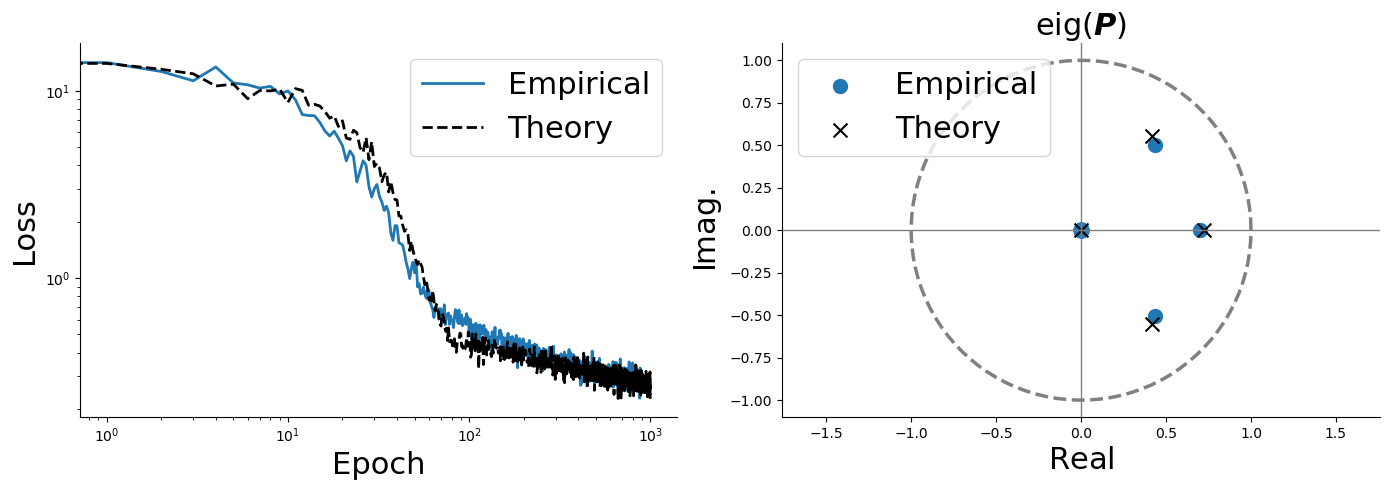

In [7]:
ST = ep_of_stab

model = model_his_parameters[ST]
m, z, u, v = model.M.detach().numpy().flatten(), model.Z.detach().numpy().flatten(), model.U.detach().numpy().flatten(), model.V.detach().numpy().flatten()
model = P_Model_eff(init_sig_zm=z@m, init_sig_zu=z@u, init_sig_vm=v@m, init_sig_vu=v@u)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) # Instantiate the optimizer
num_epochs = 1000
batch_size = 100
eff_loss, eff_model_his_parameters, eff_grad = train_model_p_eff(model, optimizer, teacher=None, white_noise=None, beta=0,
                                               w_grad_clip=1, num_epochs=num_epochs, batch_size=batch_size, num_steps=50, clamp=False)

eff_all_P = []
for ep in range(num_epochs):
    P = create_p_effective(eff_model_his_parameters[ep])
    eff_all_P.append(P)

eff_all_P = np.array(eff_all_P)
eig,_ = np.linalg.eig(eff_all_P)
stab = np.all(np.abs(eig) < 1, axis=1).astype(int)

try:
    for i in range(num_epochs):
        if stab[i] == 1 and all(stab[i:] == [1] * (len(stab) - i)):
            ep_of_stab_eff = i
            break
except:
    ep_of_stab_eff = num_epochs+1


fig, (ax0,ax1) = plt.subplots(1,2,figsize=(14,5))


ax0.plot(loss[ST:], label='Empirical',lw=2)
ax0.plot(eff_loss,ls='--',color='k', label='Theory',lw=2)

ax0.set_xlabel('Epoch',size=22)
ax0.set_ylabel('Loss',size=22)

ax0.set_yscale('log')
ax0.set_xscale('log')
ax0.legend(fontsize=22)

eig,_ = np.linalg.eig(all_P)
ax1.scatter(eig.real[-1],eig.imag[-1],marker='o',s=100, label='Empirical')

eff_all_P = np.array(eff_all_P)
eig,_ = np.linalg.eig(eff_all_P)
ax1.scatter(eig.real[-1],eig.imag[-1],color='k',marker='x',s=100, label='Theory')
ax1.axhline(0, color='grey', lw=1)
ax1.axvline(0, color='grey', lw=1)
theta = np.linspace(0, 2*np.pi, 100)
ax1.plot(np.cos(theta), np.sin(theta), color='grey', ls='--', lw=2.5)

ax1.set_title(r'$\text{eig}(\mathbfit{P})$', size=22)
ax1.set_ylabel(r'$\text{Imag.}$', size=22)
ax1.set_xlabel(r'$\text{Real}$', size=22)
ax1.legend(fontsize=22,loc='upper left')
ax1.axis('equal')


sns.despine()
plt.tight_layout()
plt.show()